In [1]:
import os
import wandb
import logging
from pytorch_lightning.utilities.seed import seed_everything

from DLIP.utils.loading.initialize_wandb import initialize_wandb
from DLIP.utils.loading.load_data_module import load_data_module
from DLIP.utils.loading.load_model import load_model
from DLIP.utils.loading.load_trainer import load_trainer
from DLIP.utils.loading.merge_configs import merge_configs
from DLIP.utils.loading.parse_arguments import parse_arguments
from DLIP.utils.loading.prepare_directory_structure import prepare_directory_structure
from DLIP.utils.loading.split_parameters import split_parameters
from DLIP.utils.cross_validation.cv_trainer import CVTrainer
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


logging.basicConfig(level=logging.INFO)
logging.info("Initalizing model")

config_files = '/home/ws/kg2371/projects/sem-segmentation/DLIP/experiments/configurations/inst_seg_20.yaml'
result_dir = './'

cfg_yaml = merge_configs(config_files)
base_path=os.path.expandvars(result_dir)
experiment_name=cfg_yaml['experiment.name']['value']

experiment_dir, config_name = prepare_directory_structure(
    base_path=base_path,
    experiment_name=experiment_name,
    data_module_name=cfg_yaml['data.datamodule.name']['value'],
    model_name=cfg_yaml['model.name']['value']
)

config = initialize_wandb(
    cfg_yaml=cfg_yaml,
    experiment_dir=experiment_dir,
    config_name=config_name
)

seed_everything(seed=cfg_yaml['experiment.seed']['value'])
parameters_splitted = split_parameters(config, ["model", "train", "data"])

model = load_model(parameters_splitted["model"],
                checkpoint_path_str='/home/ws/kg2371/projects/sem-segmentation/results/first-shot/GenericSegmentationDataModule/UnetInstance/0247/dnn_weights.ckpt'
)
data = load_data_module(parameters_splitted["data"])
trainer = load_trainer(parameters_splitted['train'], experiment_dir, wandb.run.name, data)

from DLIP.utils.post_processing.distmap2inst import DistMapPostProcessor

post_pro = DistMapPostProcessor(
    sigma_cell=1.0,
    th_cell=0.022,
    th_seed=0.25,
    do_splitting=False,
    do_area_based_filtering=False,
    do_fill_holes=False,
    valid_area_median_factors=[0.25,3]
)

/home/ws/kg2371/anaconda3/envs/sem-segmentation/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
INFO:root:Initalizing model
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Global seed set to 1234
INFO:root:Loading imagenet weights
/home/ws/kg2371/anaconda3/envs/sem-segmentation/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:2610: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
INFO:root:Using 32 workers for data loading
INFO:root:Length of validation dataset: 24
INFO:root:Length of test dataset: 32
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU av

In [4]:
test_dl = data.test_dataloader()
xs = np.zeros((0,1,1024,1024))
y_trues = np.zeros((0,1,1024,1024))
y_trues_dist_maps = np.zeros((0,1,1024,1024))
y_preds = np.zeros((0,1,1024,1024))


for batch in tqdm(test_dl):
    x, y_true, y_true_dist_map   = batch
    y_true      = y_true.permute(0, 3, 1, 2)
    y_true_dist_map      = y_true_dist_map.unsqueeze(1)
    y_pred = model(x)
    
    xs = np.concatenate((xs,x.detach().cpu().numpy()))
    y_trues = np.concatenate((y_trues,y_true.detach().cpu().numpy()))
    y_trues_dist_maps = np.concatenate((y_trues_dist_maps,y_true_dist_map.detach().cpu().numpy()))
    y_preds = np.concatenate((y_preds,y_pred.detach().cpu().numpy()))
    
    

100%|██████████| 8/8 [00:20<00:00,  2.54s/it]


In [7]:
inst_segmentations = post_pro.process(y_preds[3],None)

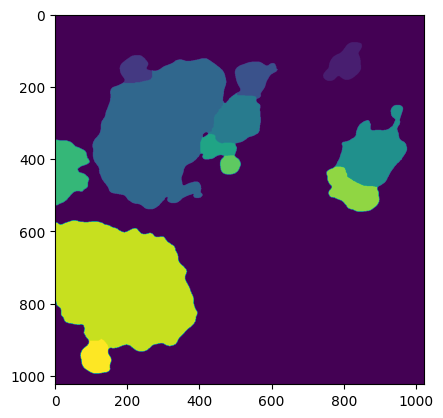

In [8]:
plt.imshow(inst_segmentations[0])